In [172]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
from random import random

Helper functions

In [173]:
class Params:
    def __init__(self):
        self.grid_resolution = 0.01
        self.dist_to_reach_goal = 0.5
        self.maxiters = 1000
        self.smoothiters = 150

In [174]:
class Robot:
    def __init__(self):
        self.p = [0, 0]
        self.ballradius = 0.5

In [175]:
class Node:
    def __init__(self):
        self.p     = [0, 0]
        self.iPrev = 0

In [176]:
# Helper functions
from matplotlib import path

def isCollisionFreeVertex(robot, obstacles):
    # the function calculates value:
    # collFree = [xy-point is outside obstacles map]
    collFree = 1
    xy = robot.p
    for obstacle in obstacles:
        hull = path.Path(obstacle)
        collFree = not hull.contains_points([xy])
        if hull.contains_points([xy]):
#             print('collision Vertex')
            return 0

    return collFree

In [177]:
def isCollisionFreeEdge(robot, obstacles, p1, p2, map_resolution=0.01):
    p1 = np.array(p1); p2 = np.array(p2)
    collFree = 1
    l = norm(p1 - p2)
    M = int(l / map_resolution)
    if M <= 2: M = 11
    t = np.linspace(0,1,M)
    for i in range(1,M-1):
        p = (1-t[i])*p1 + t[i]*p2 # calculate configuration
        robot.p = p
        collFree = isCollisionFreeVertex(robot, obstacles) 
        if collFree == 0:
#             print('collision Edge')
            return 0

    return collFree

In [178]:
def AddNode(rrt, p, iPrev):
    node = Node()
    node.p = p
    node.iPrev = iPrev
    rrt.append( node )
    return rrt

In [179]:
def PlanPathRRT(robot, obstacles, param, p_start, p_goal):
    P = []
    rrt = []
    rrt = AddNode(rrt, p_start, 0)
    iteration = 1
    while iteration <= param.maxiters:
        p = np.random.rand(2)
        p[0] = p[0]*5-2.5
        p[1] = p[1]*5-2.5
        robot.p = p
        collisionFree = isCollisionFreeVertex(robot, obstacles)
        if collisionFree == 0: # skip to next iteration
            iteration += 1
            continue
        
        # do something if valid coordinate
        for i in range(len(rrt)):
            dist = norm(rrt[i].p - p)
            if (i==0) or (dist < mindist):
                mindist = dist
                imin = i
                l = rrt[imin].p

        collision = isCollisionFreeEdge(robot, obstacles, p, l, param.grid_resolution) # check for valid edge
        if collision == 0: # skip to next iteration if not valid edge
            iteration = iteration + 1
            continue
        rrt = AddNode(rrt, p, imin) # add p to RRT with parent l
        dist = norm(p-p_goal)

        if (dist < param.dist_to_reach_goal):
            print('Near the goal')
            collisionFree = isCollisionFreeEdge(robot, obstacles, p, p_goal, param.grid_resolution) # check for valid edge
            if collisionFree == 0: # skip to next iteration if not valid edge
                iteration = iteration + 1
                continue 
                
            iterations = iteration
            # add qgoal to RRT with parent q and exit with success
            rrt = AddNode(rrt, p_goal, len(rrt))

#             construct P here:
            i = len(rrt)
            P = np.array( rrt[-1].p )
#             while 1:
#                 i = rrt[i].iPrev
#                 print(i)
#                 if i == 0:
#                     return
    
#                 P = np.append([P, rrt[i].p])
            for j in range(len(rrt)-1,0,-1):
                i_path = rrt[j].iPrev
                P = np.vstack([P, rrt[i_path].p])
                if i_path==0:
                    print('Number of iterations: ', iteration)
                    return P
        iteration = iteration + 1

Near the goal
('Number of iterations: ', 147)


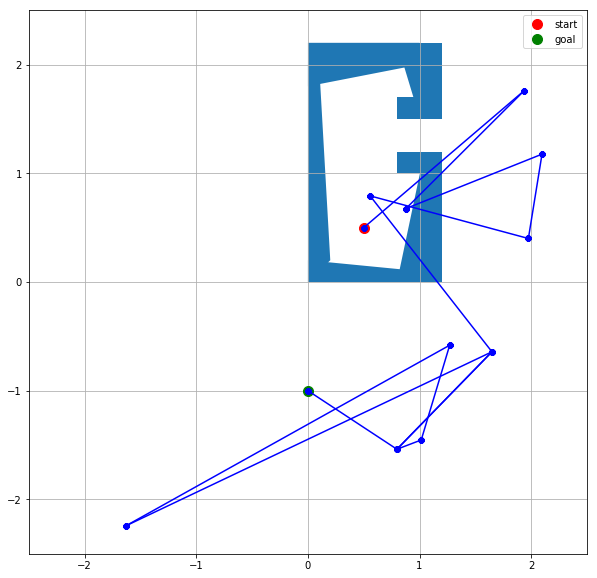

In [206]:
# Obstacle Locations
w = 0.2
obstacles = [
              np.array([[0, 0], [1, 0], [1, 0.1], [0, w]]),
              np.array([[0, 0], [w, 0.2], [0.1, 2], [0.0, 2.0]]),
              np.array([[0, 2-w], [1, 2], [1, 2+w], [0, 2+w]]),
              np.array([[1-w, 0], [1+w, 0], [1+w, 1], [1, 1]]),
              np.array([[1-w, 2+w], [1+w, 2+w], [1+w, 1.5], [1, 1.5]]),
              np.array([[0.8, 1], [1+w, 1], [1+w, 1+w], [0.8, 1+w]]),
              np.array([[0.8, 1.5], [1+w, 1.5], [1+w, 1.5+w], [0.8, 1.5+w]])
            ]
# obstacles = []


# Set Start and Goal locations
p_start = [0.5, 0.5]
p_goal = [0, -1]

# initialization
robot = Robot()
robot.ballradius = 0.5
robot.p = p_start

node = Node()
param = Params()


from matplotlib.patches import Polygon

# Bounds on world
world_bounds_x = [-2.5, 2.5]
world_bounds_y = [-2.5, 2.5]


# Draw obstacles
fig = plt.figure(figsize=(10, 10))
plt.grid()
ax = plt.gca()
ax.set_xlim(world_bounds_x)
ax.set_ylim(world_bounds_y)
for k in range(len(obstacles)):
    ax.add_patch( Polygon(obstacles[k]) )
    
plt.plot(p_start[0], p_start[1], 'ro', color='red', markersize=10, label='start')
plt.plot(p_goal[0], p_goal[1], 'ro', color='green', markersize=10, label='goal')
plt.legend()

# Plan the path
P = PlanPathRRT(robot, obstacles, param, p_start, p_goal)


# Plot the path from RRT
for i in range(1,len(P)):
    plt.plot([P[i,0], P[i-1,0]], [P[i,1], P[i-1,1]], color='blue')
    plt.plot(P[:,0], P[:,1], 'ro', color='blue', markersize=5)